In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [ ]:
df.shape

(169, 2)

In [ ]:
df.rename(columns ={'Monthly milk production: pounds per cow. Jan 62 ? Dec 75': 'Milk produced'}, inplace=True)

In [ ]:
df.head()

,Month,Milk produced
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [ ]:
df.tail()

,Month,Milk produced
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [ ]:
df.drop(168,axis = 0,inplace = True)

In [ ]:
df['Month'] = pd.to_datetime(df['Month'])

In [ ]:
df.set_index('Month',inplace=True)

In [ ]:
df.shape

(168, 1)

In [ ]:
df.tail()

,Milk produced
Month,
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0
1975-11-01,797.0
1975-12-01,843.0


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk produced,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


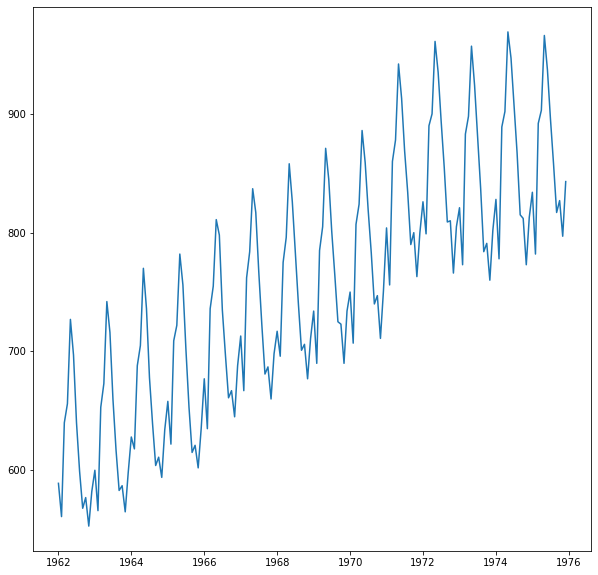

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(df['Milk produced'])

In [ ]:
timeseries = df['Milk produced']

In [ ]:
type(timeseries)

pandas.core.series.Series

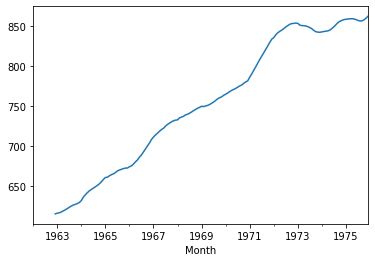

In [ ]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')

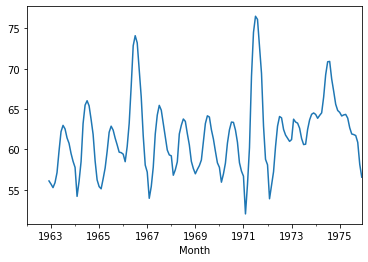

In [ ]:
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')

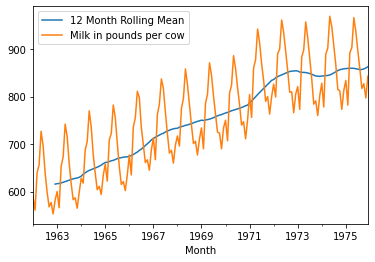

In [ ]:
timeseries.rolling(12).mean().plot(label = '12 Month Rolling Mean')
timeseries.plot()
plt.legend()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose #### classical decomposition

In [ ]:
decomposition = seasonal_decompose(df['Milk produced'],freq = 12)  

<Figure size 432x288 with 0 Axes>

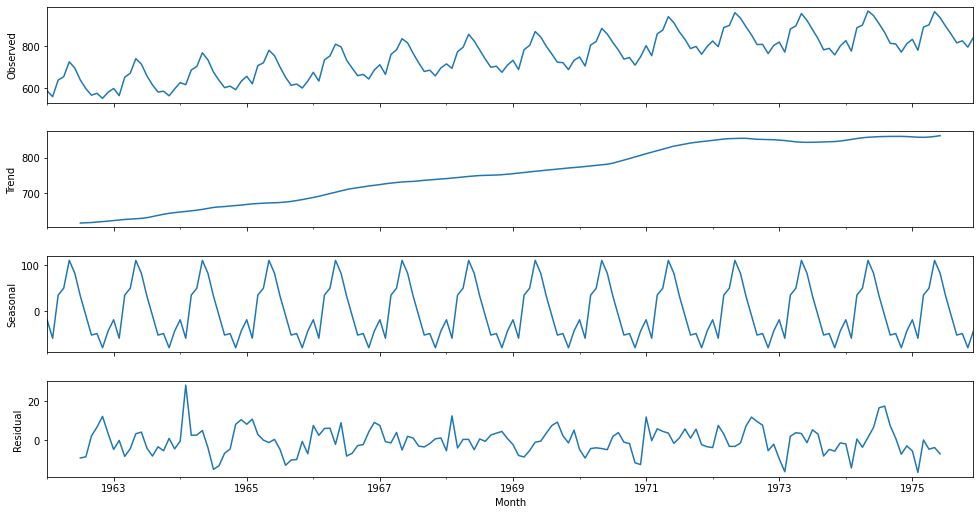

In [ ]:
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [ ]:
df.head()

,Milk produced
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic',
              'p-value',
              '#Lags Used',
              'Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
result = adf_check(timeseries)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221299
p-value : 0.6274267086030314
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [ ]:
df['Milk produced']

Month
1962-01-01    589.0
1962-02-01    561.0
1962-03-01    640.0
1962-04-01    656.0
1962-05-01    727.0
              ...  
1975-08-01    858.0
1975-09-01    817.0
1975-10-01    827.0
1975-11-01    797.0
1975-12-01    843.0
Name: Milk produced, Length: 168, dtype: float64

In [ ]:
df['Milk produced'].shift(1)

Month
1962-01-01      NaN
1962-02-01    589.0
1962-03-01    561.0
1962-04-01    640.0
1962-05-01    656.0
              ...  
1975-08-01    896.0
1975-09-01    858.0
1975-10-01    817.0
1975-11-01    827.0
1975-12-01    797.0
Name: Milk produced, Length: 168, dtype: float64

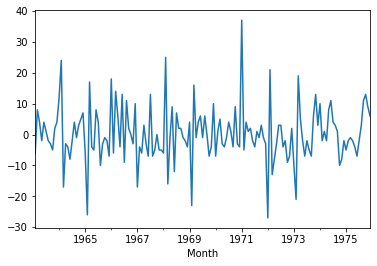

In [ ]:
trend_removed = df['Milk produced'] - df['Milk produced'].shift(1)  #### First order normal differencing

trend_seasonality_removed = trend_removed - trend_removed.shift(12) #### First order seasonal differencing

trend_seasonality_removed = trend_seasonality_removed.dropna()

trend_seasonality_removed.plot()

In [ ]:
print(adf_check(trend_seasonality_removed)) ### first order seasonal differencing and first order trend differencing

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.038002274921983
p-value : 1.865423431878848e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
None


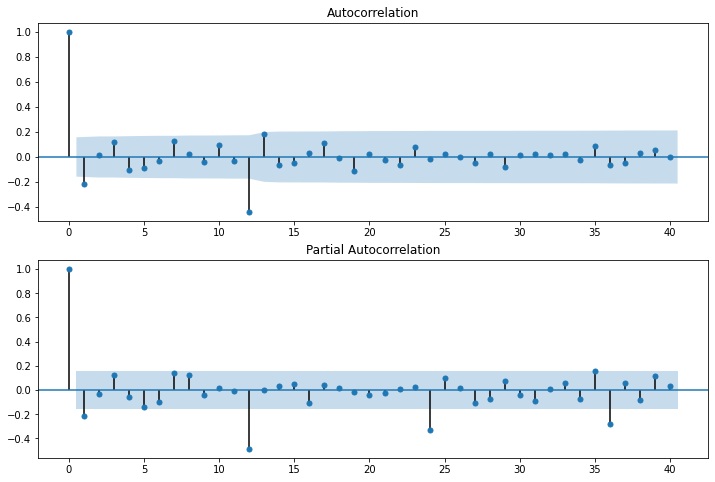

In [ ]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_seasonality_removed,lags = 40,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_seasonality_removed,lags = 40, ax = ax2)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model = sm.tsa.statespace.SARIMAX(df['Milk produced'],order = (0,1,1),seasonal_order = (0,1,1,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      Milk produced   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -530.148
Date:                            Thu, 30 Dec 2021   AIC                           1066.296
Time:                                    04:18:42   BIC                           1075.427
Sample:                                01-01-1962   HQIC                          1070.005
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2204      0.076     -2.898      0.004      -0.369      -0.071
ma.S.L12      -0.6214      0.070   

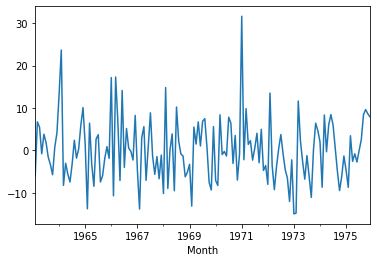

In [ ]:
results.resid[13:].plot()

In [ ]:
results.predict(start= 118, end = 128,dynamic = True) ### forecast the value for 118th month using the model

,Milk produced
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0
...,...
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0


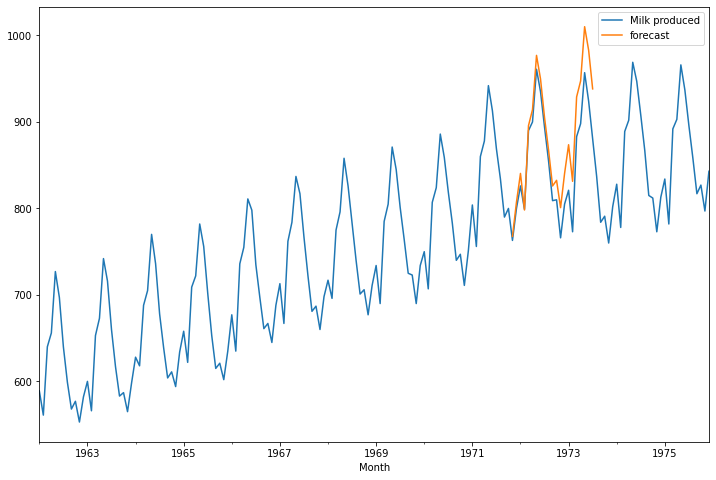

In [ ]:
df['forecast'] = results.predict(start= 118, end = 138,dynamic = True)  
df[['Milk produced','forecast']].plot(figsize = (12, 8))

In [ ]:
df.tail()

,Milk produced,forecast
Month,,
1975-08-01,858.0,NaN
1975-09-01,817.0,NaN
1975-10-01,827.0,NaN
1975-11-01,797.0,NaN
1975-12-01,843.0,NaN


In [ ]:
results.predict(start= 168, end = 180,dynamic = True)

1976-01-01     864.977273
1976-02-01     817.749359
1976-03-01     924.405590
1976-04-01     937.483635
1976-05-01    1000.623488
1976-06-01     973.216471
1976-07-01     931.850088
1976-08-01     892.259738
1976-09-01     846.367874
1976-10-01     851.532575
1976-11-01     817.493091
1976-12-01     859.753316
1977-01-01     882.814946
Freq: MS, dtype: float64

In [ ]:
from pandas.tseries.offsets import DateOffset

In [ ]:
future_dates = [df.index[-1] + DateOffset(months = x) for x in range(0,14)]

In [ ]:
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00')]

In [ ]:
future_dates_df = pd.DataFrame(index = future_dates[1:],columns = df.columns)

In [ ]:
future_df = pd.concat([df,future_dates_df])

In [ ]:
future_df.tail()

,Milk produced,forecast
1976-09-01,NaN,NaN
1976-10-01,NaN,NaN
1976-11-01,NaN,NaN
1976-12-01,NaN,NaN
1977-01-01,NaN,NaN


In [ ]:
future_df.tail()

,Milk produced,forecast
1976-09-01,NaN,NaN
1976-10-01,NaN,NaN
1976-11-01,NaN,NaN
1976-12-01,NaN,NaN
1977-01-01,NaN,NaN


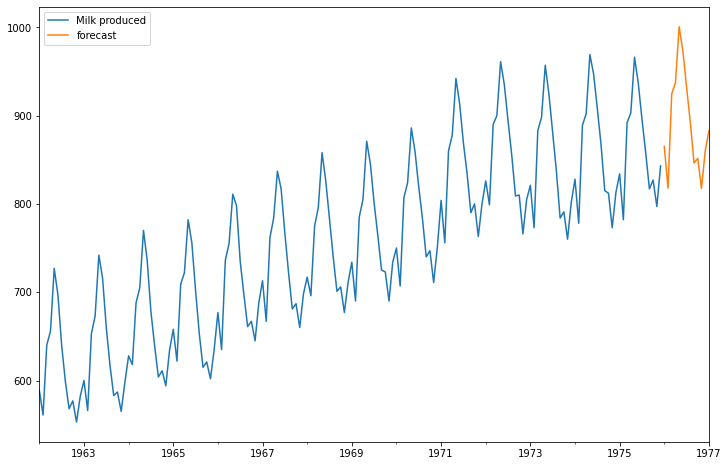

In [ ]:
future_df['forecast'] = results.predict(start = 168, end = 180,dynamic= True)  
future_df[['Milk produced', 'forecast']].plot(figsize = (12, 8)) 